**Package imports**

In [1]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import yfinance as yf
import pendulum
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf
import csv
from pandas_datareader import data as pdr
import pandas as pd
from scipy.stats import norm
from random import randint
from datetime import datetime
%matplotlib inline
%pylab inline
yf.pdr_override()

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\stockPredict\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint', 'datetime', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Parameter Initialization**

In [2]:
# Set the data source
#FILE_NAME = 'hk_price.txt'
FILE_NAME = 'hk_price_100k.txt'

# Check how many lines in the file
DATA_ROWS_NUM = 100000

# Catch the first several segments
MAX_SEG_TO_CATCH = 200

# How many days per segment 
DAY_PER_SEG = 30

# How many days to save image for testing
DAY_PER_IMAGE = 30

# Consider OPEN price or not
ADD_OPEN_PRICE = False

# '''Decide to use segmation method 1 or method 2'''
# USE_20_DAYS_SEG = True


**Data Initialization**

In [3]:
def get_stock_dataframe(tickers , startDate , endDate, interval):
  df = pdr.get_data_yahoo(tickers, start = startDate, end = endDate, interval=interval)
  return df

startDate = "2000-01-25"
endDate = "2022-01-25"
df = get_stock_dataframe('AAPL' , startDate , endDate, "1d")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-24,0.968192,1.006696,0.938616,0.948661,0.812314,440876800
2000-01-25,0.937500,1.010045,0.914063,1.002232,0.858185,497145600
2000-01-26,0.982143,1.019531,0.979911,0.983817,0.842417,367158400
2000-01-27,0.971540,1.008929,0.955357,0.982143,0.840984,340144000
2000-01-28,0.965960,0.989955,0.898438,0.907366,0.776954,423348800
...,...,...,...,...,...,...
2022-01-18,171.509995,172.539993,169.410004,169.800003,169.583939,90956700
2022-01-19,170.000000,171.080002,165.940002,166.229996,166.018478,94815000
2022-01-20,166.979996,169.679993,164.179993,164.509995,164.300659,91420500


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5.537000e+03
mean,24.742224,25.005763,24.479760,24.752336,23.638070,4.275724e+08
std,35.452341,35.851648,35.065290,35.472918,35.341573,3.889772e+08
min,0.231964,0.235536,0.227143,0.234286,0.200613,3.934000e+07
25%,1.566786,1.585000,1.546786,1.568036,1.342669,1.574440e+08
50%,11.785714,11.916786,11.668571,11.829643,10.129418,3.114272e+08
75%,30.197500,30.347500,29.932501,30.132500,27.965151,5.676916e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [5]:
data = df.values
dataset = []

for i in range(len(data)):
    dataset.append(dict(date = str(df.index[i]).split(' ')[0] , open = data[i][0] , high = data[i][1] , low = data[i][2] , close = data[i][3]))
dataset[0]

{'date': '2000-01-24',
 'open': 0.9681919813156128,
 'high': 1.0066959857940674,
 'low': 0.9386159777641296,
 'close': 0.9486610293388367}

In [6]:
preYear="2000"
seg_index = 0
date_per_seg = 0
X_seg =[[] for x in range(MAX_SEG_TO_CATCH)]
for row in dataset:
    curYear = dataset[0]['date'].split("-")[0]
    if(curYear != preYear):
        preYear = curYear
        date_per_seg = 0
        seg_index += 1
    if(date_per_seg >= DAY_PER_SEG):
        date_per_seg = 0
        seg_index += 1
    if(seg_index>= MAX_SEG_TO_CATCH):
        break
    X_seg[seg_index].append(row)
    date_per_seg = date_per_seg + 1

In [7]:
def findMaxInSegment(seg):
    max_price = 0
    max_ind = 0
    for ind, row in enumerate(seg):
        if (float(row['close']) > max_price):
            max_price = float(row['close'])
            max_ind = ind
    return (max_ind, max_price)

In [8]:
def getSlope(x1, y1, x2, y2, isABS):
    if (x2 - x1) != 0:
        slope = (y2 - y1)/(x2 - x1)
        if (slope > 0) or (not isABS):
            return slope
        else:
            return slope * (-1)
    else:
        raise ValueError('Zero Division')

In [9]:
def findUpperBoundGivenSegment(seg, max_ind, max_price):

    min_slope = 1
    # The second point who underpin the upper bound
    sec_ind = 0
    sec_price = 0
    
    for ind, row in enumerate(seg):
        price = float(row['close'])
        # Different from the max point
        if(ind != max_ind):
            ABSslope = getSlope(max_ind, max_price, ind, price, True)
            # Flatter slope found!!
            if(min_slope > ABSslope):
                sec_ind = ind
                sec_price = price
                min_slope = ABSslope
                
    return (sec_ind, sec_price)

In [10]:
def findLineViaTwoPoints(x1,y1,x2,y2):
    slope = getSlope(x1,y1,x2,y2, False)
    y0 = y1 - x1 * slope
    y3 = (19 - x1) * slope + y1
    return ([0,19], [y0,y3])

In [11]:
def plotBySegment(seg, ind):
    y = []
    length = len(seg)
    if(length > 0):
        date = seg[length-1]['date'] + " to " + seg[0]['date']
    else:
        date = "NA"
    
    # for each data, records its open price and close price
    for row in seg:
        if ADD_OPEN_PRICE:
            y.append(row['open'])
        y.append(row['close'])
        

    
    (max_ind, max_price) = findMaxInSegment(seg)
    (sec_ind, sec_price) = findUpperBoundGivenSegment(seg, max_ind, max_price)
    
    (line_x, line_y) = findLineViaTwoPoints(max_ind,max_price,sec_ind,sec_price)
    
    # Plot the figure for each segment
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("#" + str(ind) + " | " + date + " | num of data: " + str(length))
    ax.plot(y)
    
    #
    ax.plot(line_x, line_y)
      

In [12]:
def plotCandleBySegment(seg, ind):
    y = []
    length = len(seg)
    if(length > 0):
        date = seg[0]['date'] + " to " + seg[length-1]['date']
    else:
        date = "NA"
    
    # for each data, records its open price and close price
    for i, row in enumerate(seg): # (close, high, low, open)
        y.append((i, float(row['open']), float(row['high']), float(row['low']), float(row['close'])))

    
    # Plot the figure for each segment
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("#" + str(ind) + " | " + date + " | num of data: " + str(length))
    #ax.plot(y)
    candlestick_ohlc(ax, y, width=0.6)
    plt.show()


C:\ProgramData\Anaconda3\envs\stockPredict\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


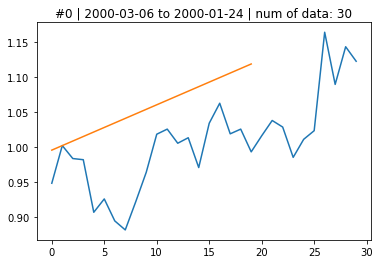

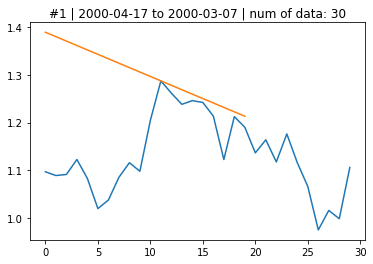

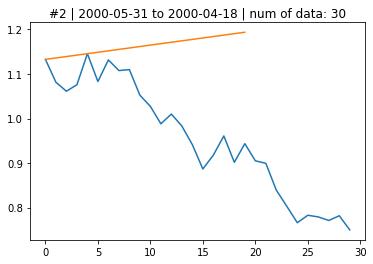

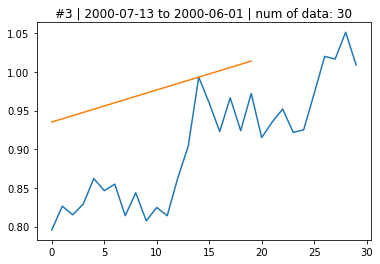

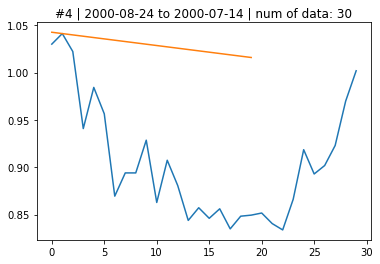

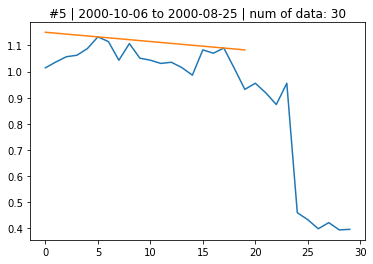

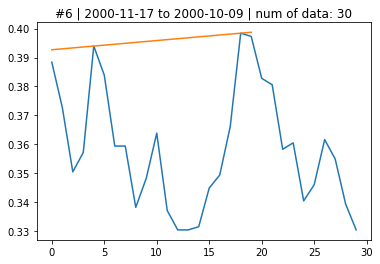

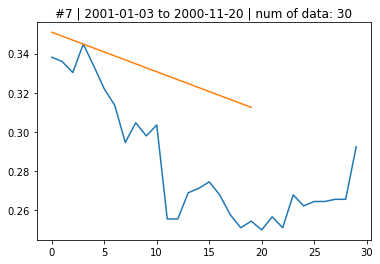

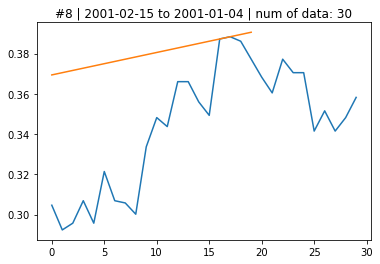

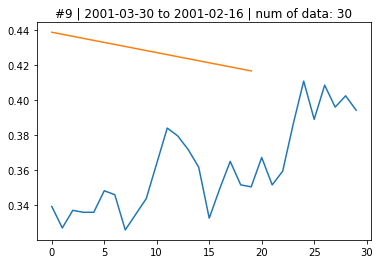

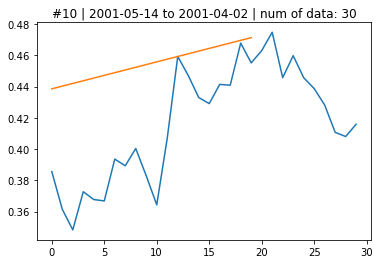

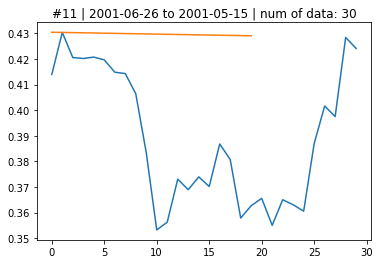

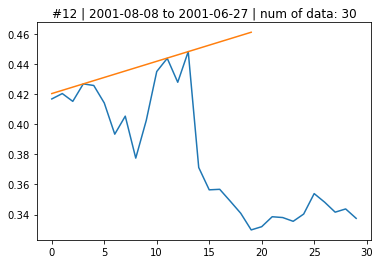

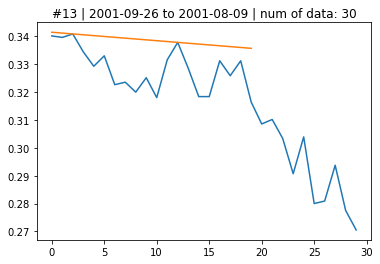

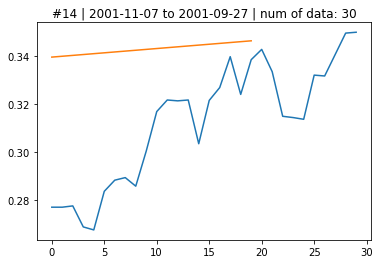

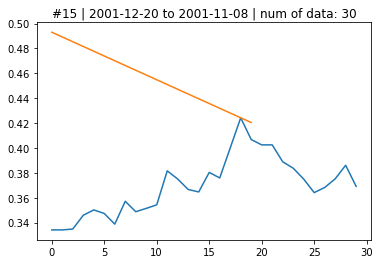

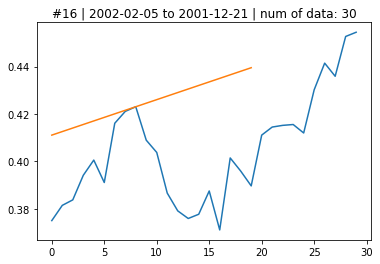

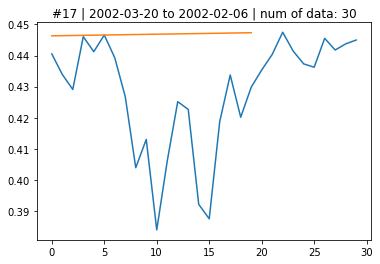

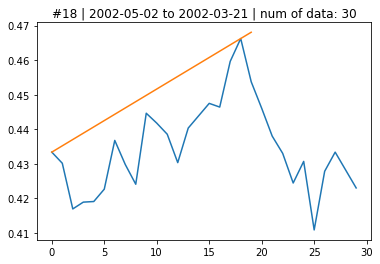

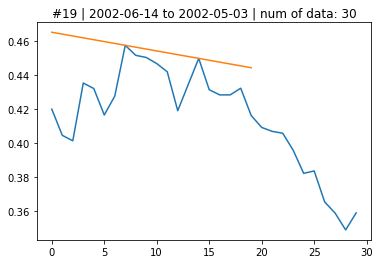

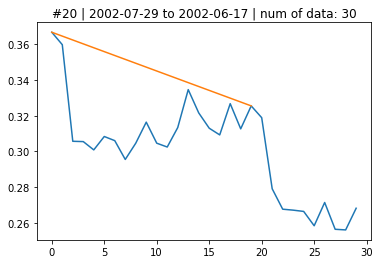

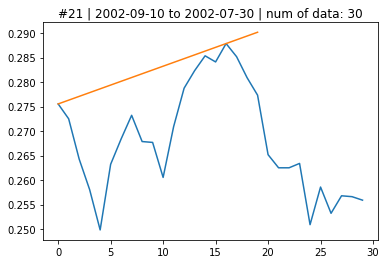

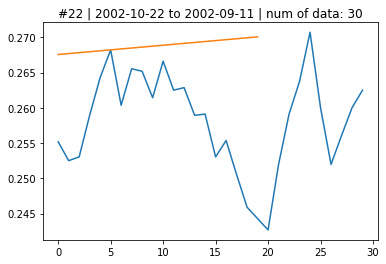

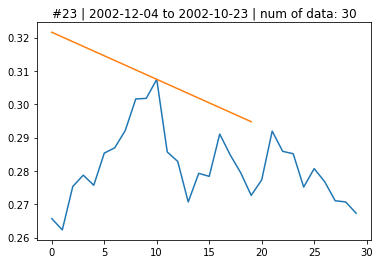

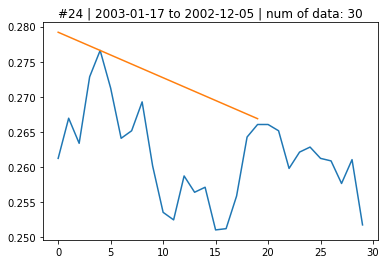

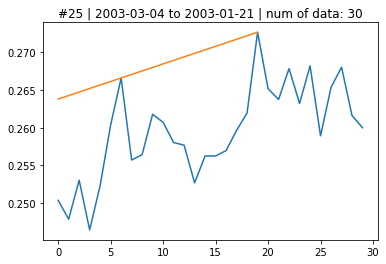

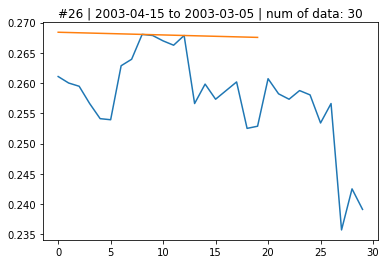

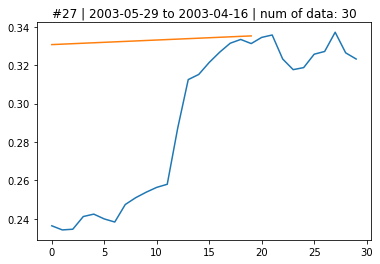

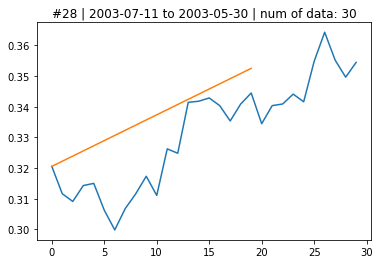

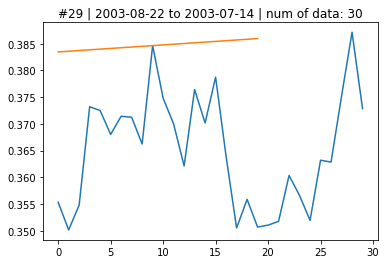

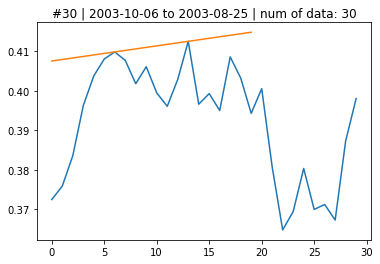

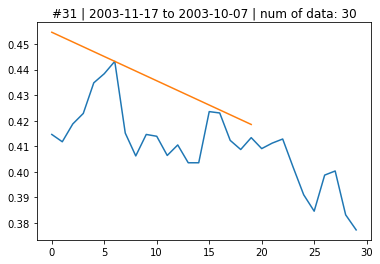

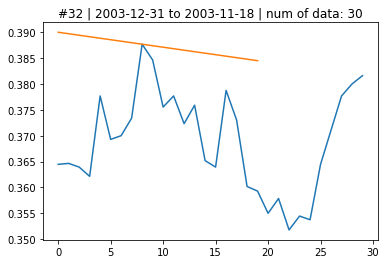

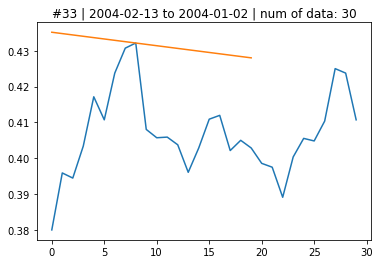

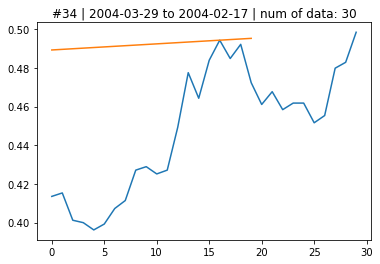

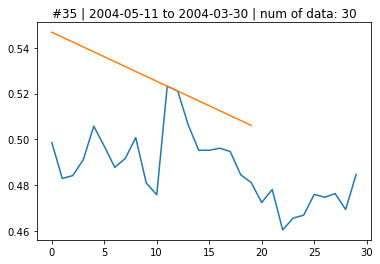

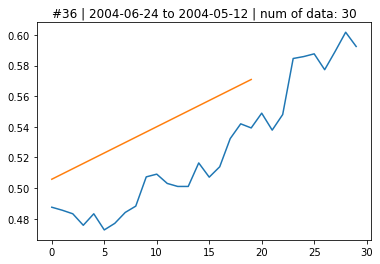

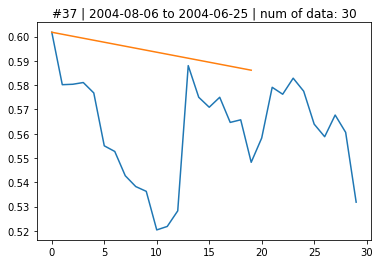

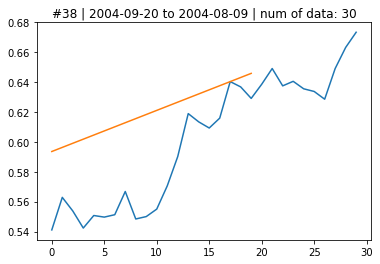

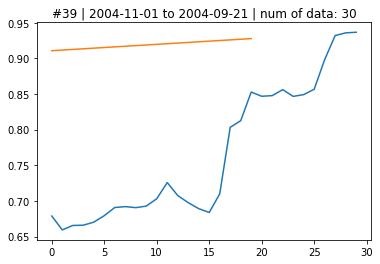

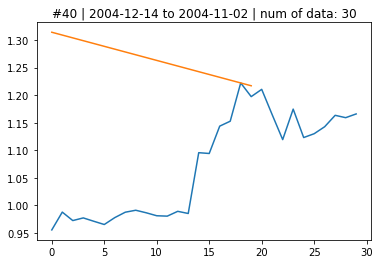

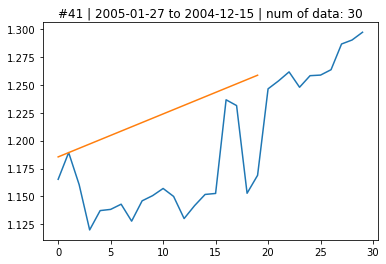

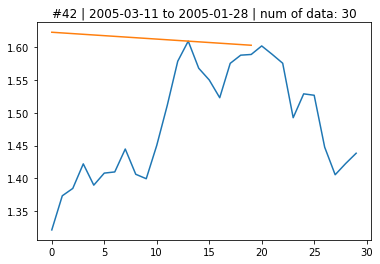

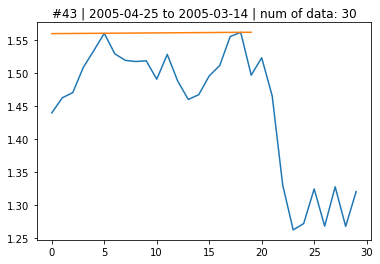

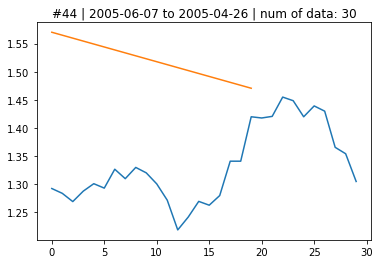

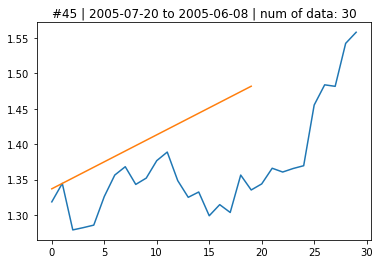

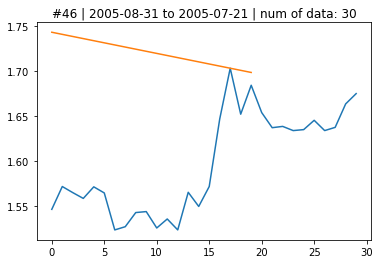

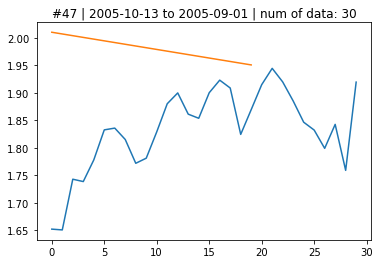

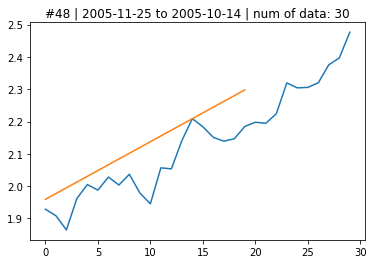

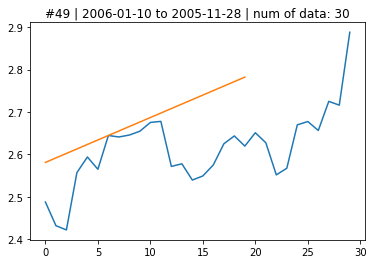

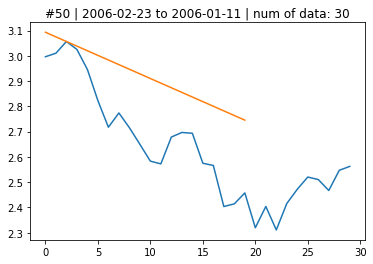

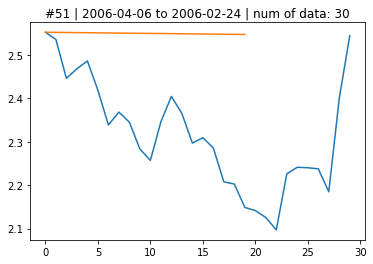

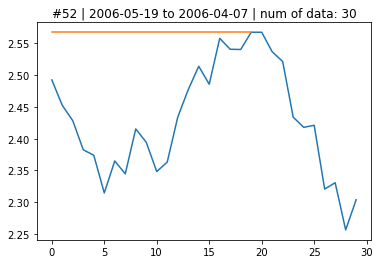

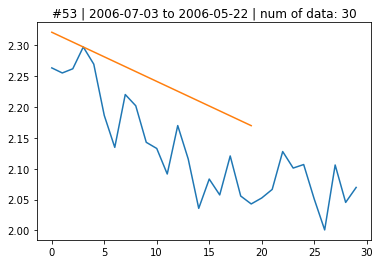

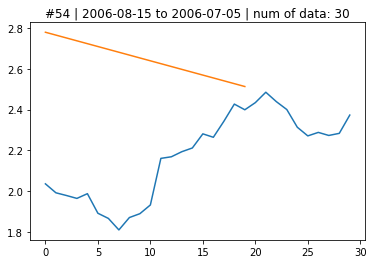

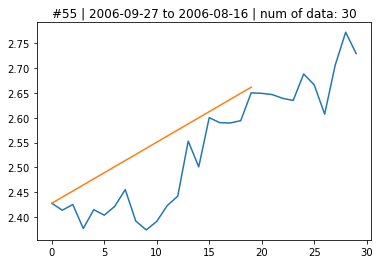

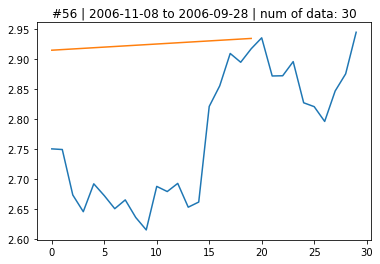

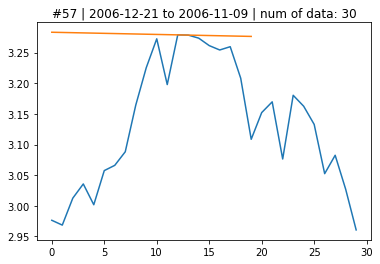

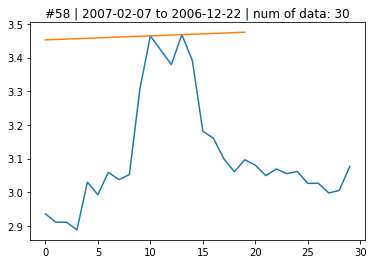

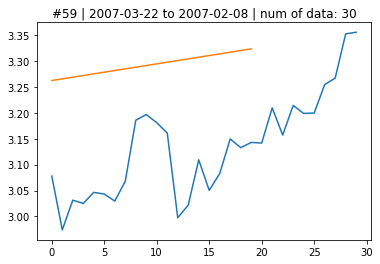

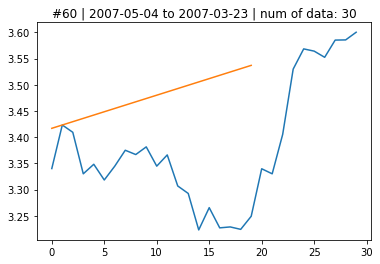

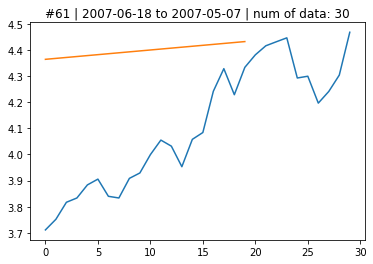

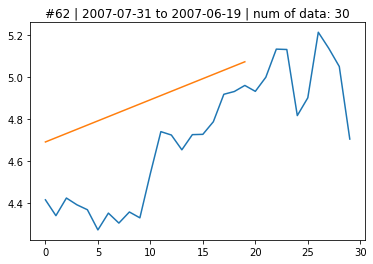

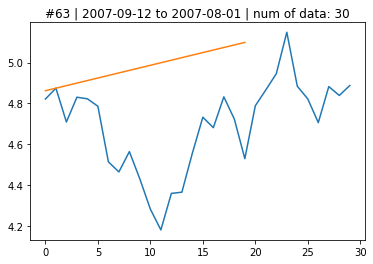

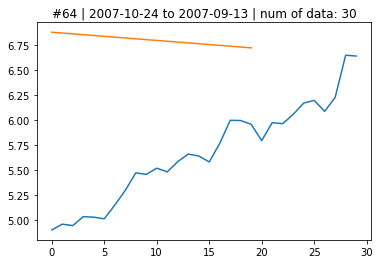

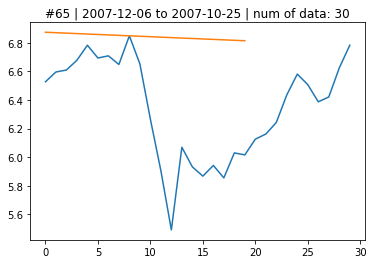

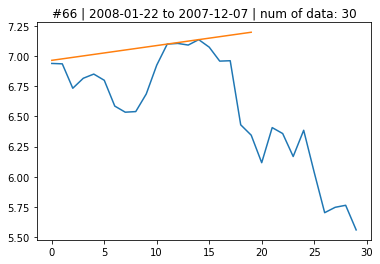

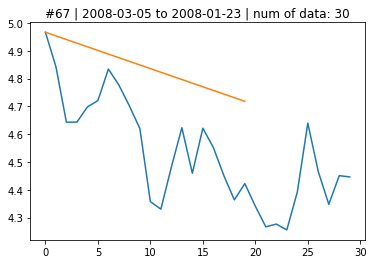

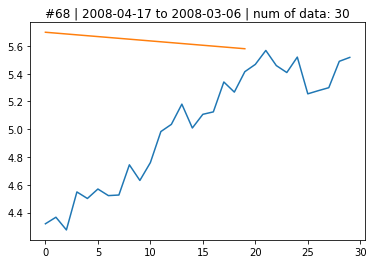

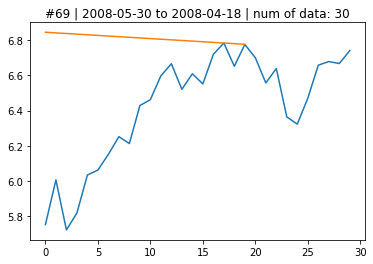

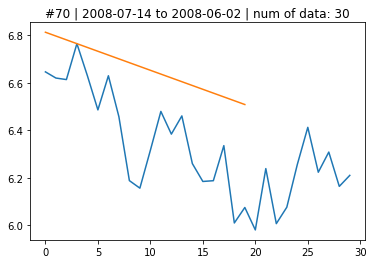

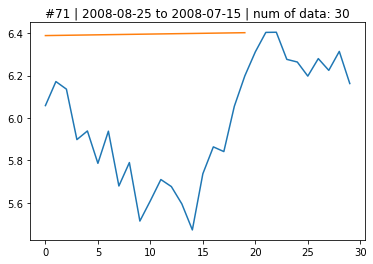

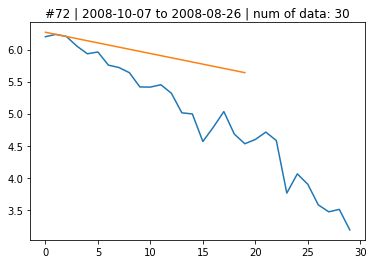

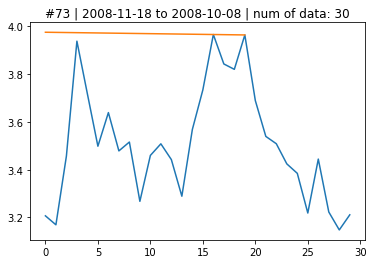

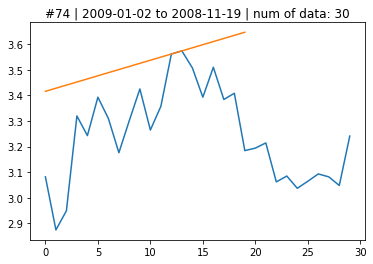

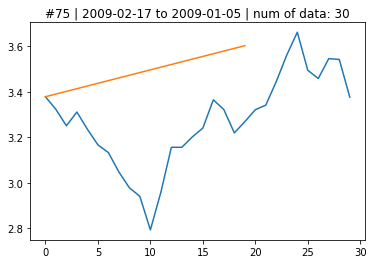

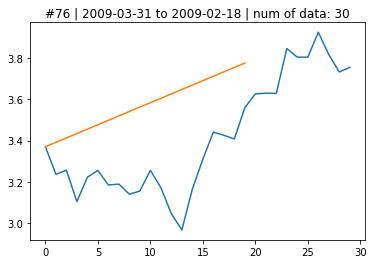

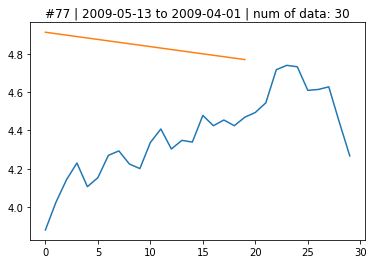

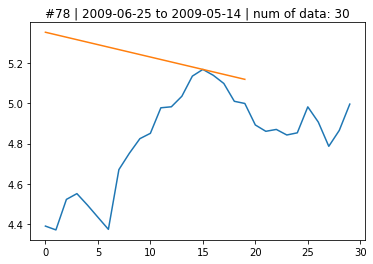

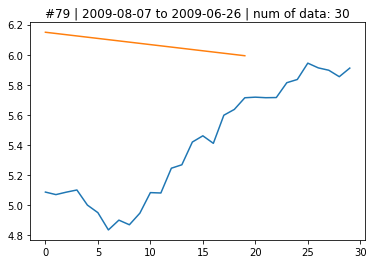

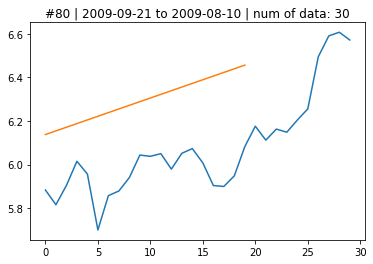

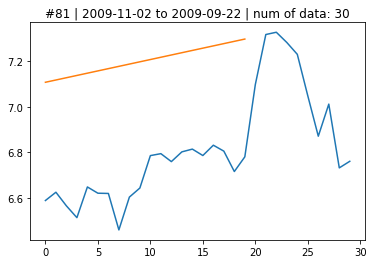

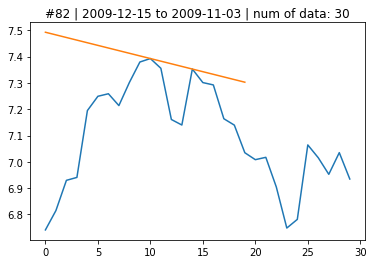

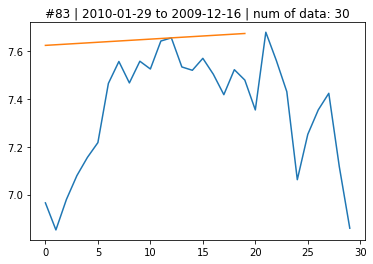

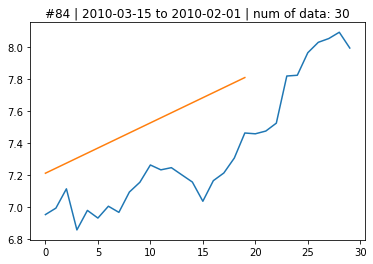

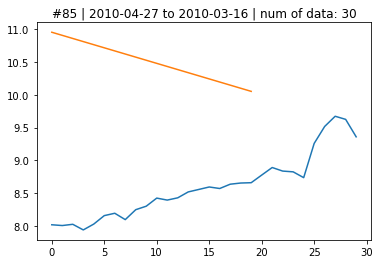

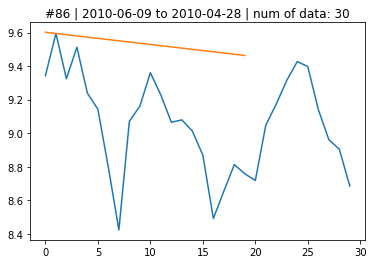

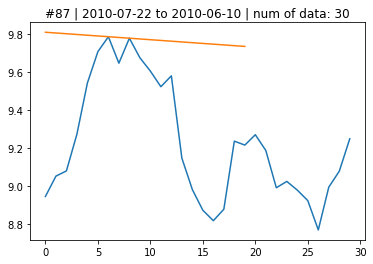

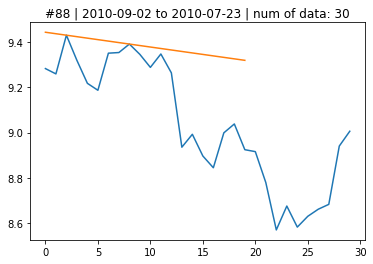

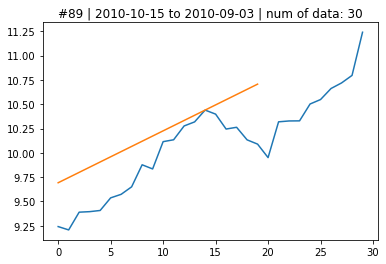

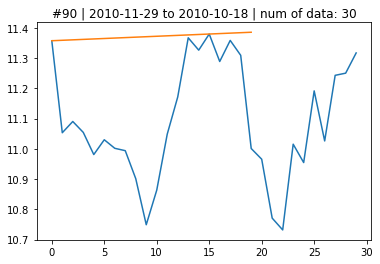

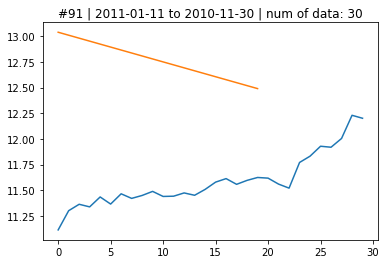

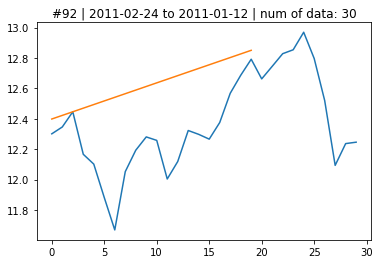

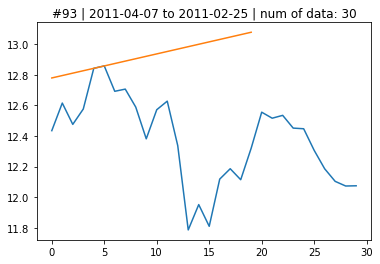

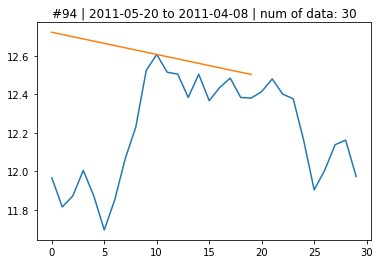

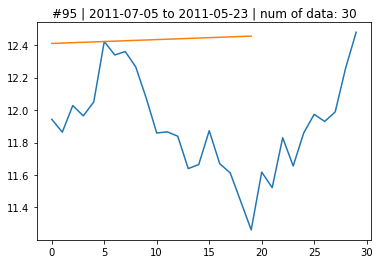

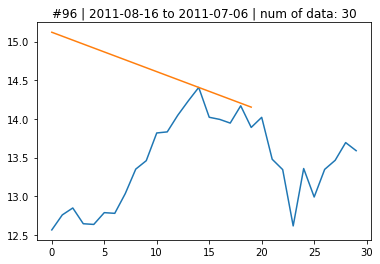

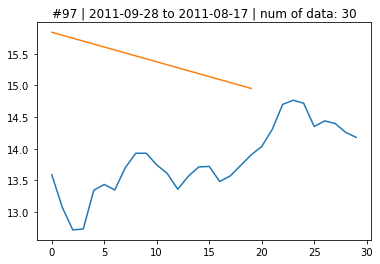

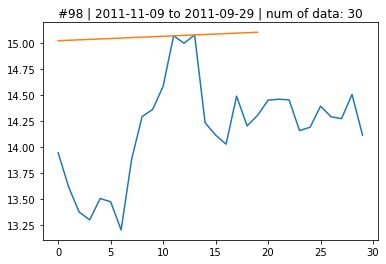

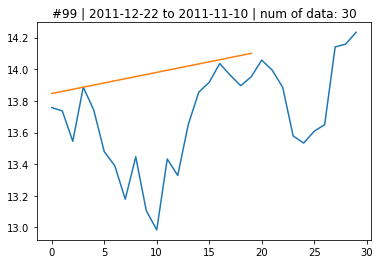

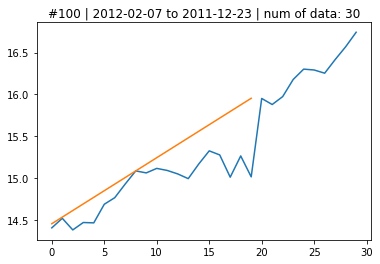

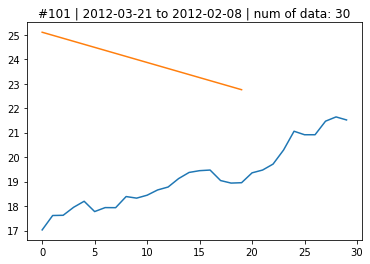

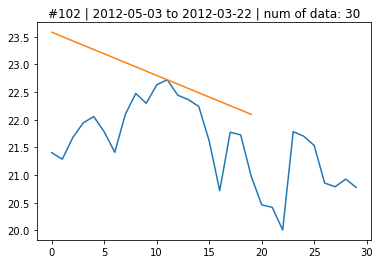

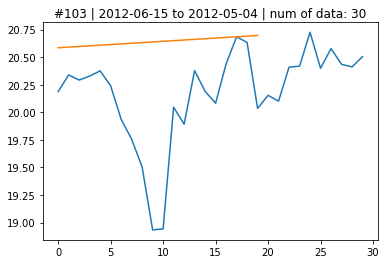

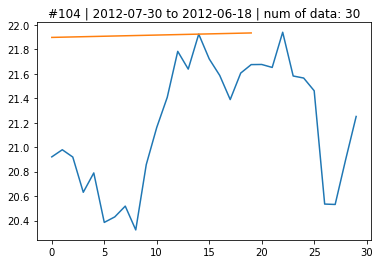

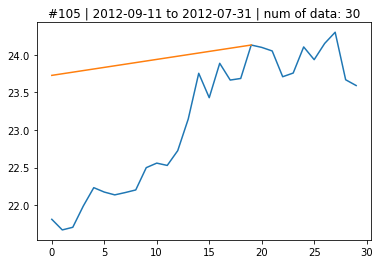

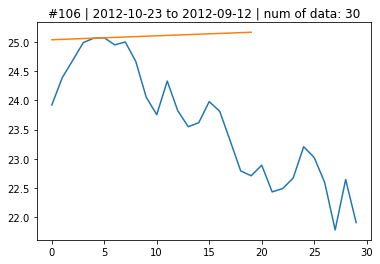

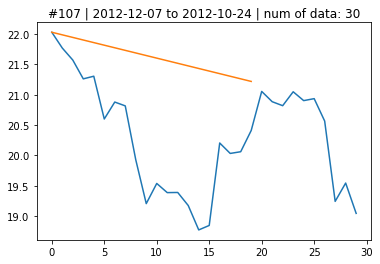

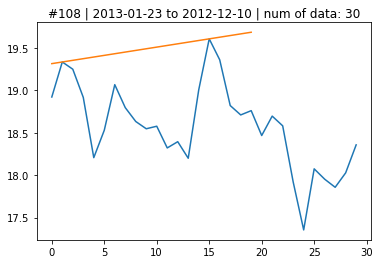

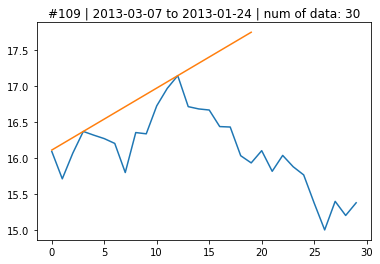

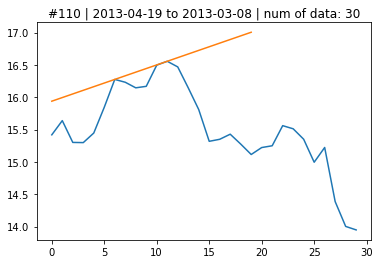

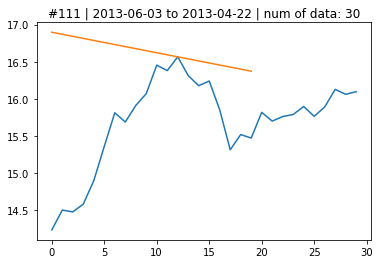

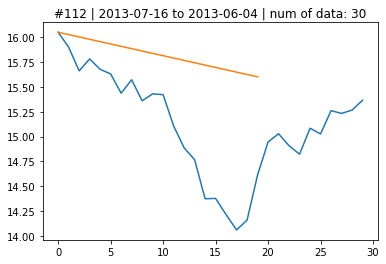

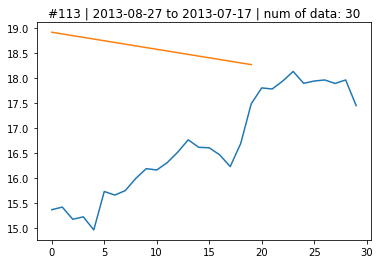

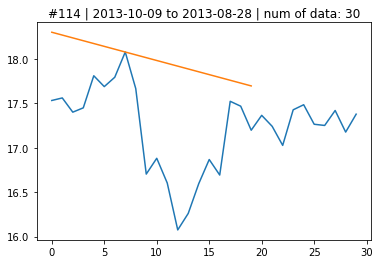

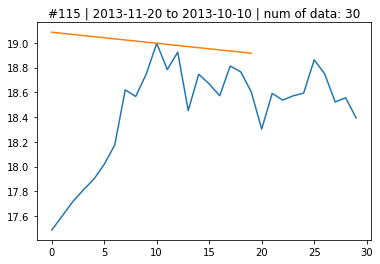

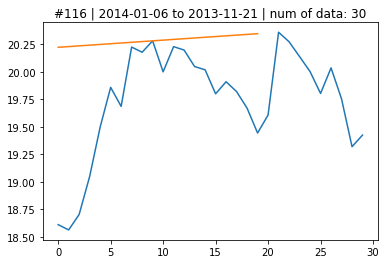

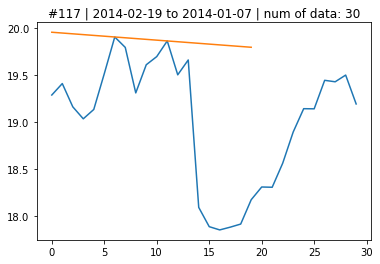

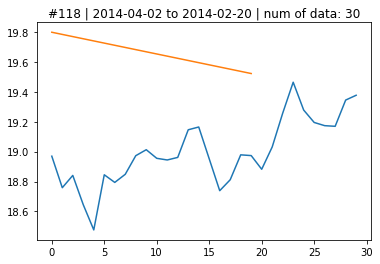

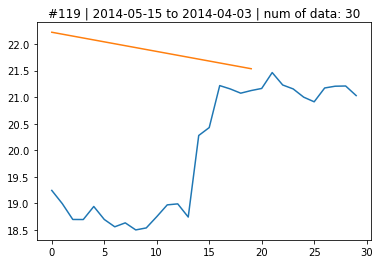

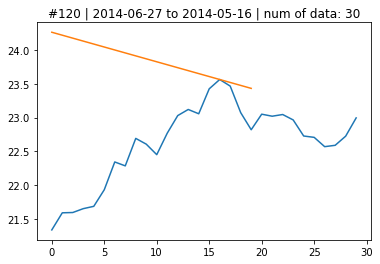

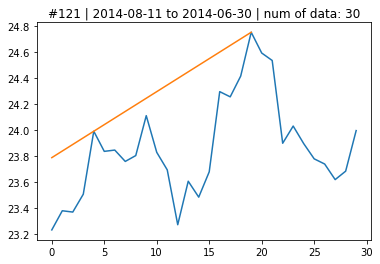

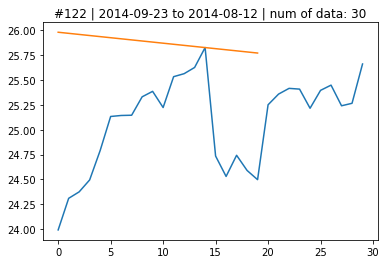

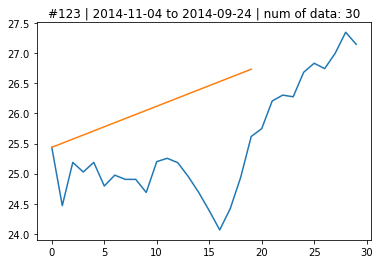

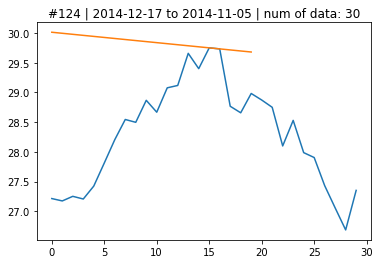

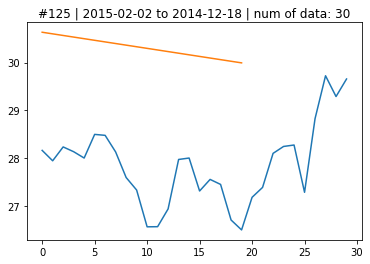

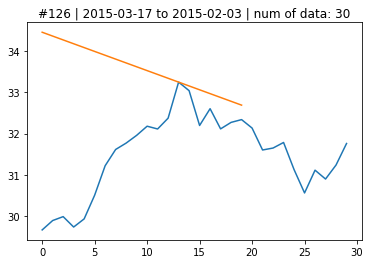

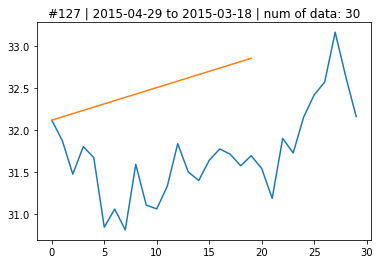

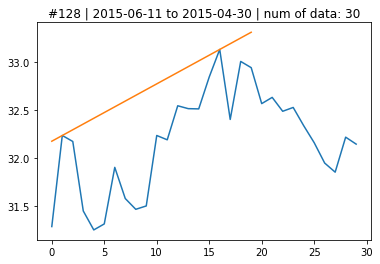

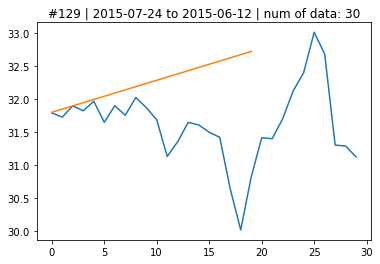

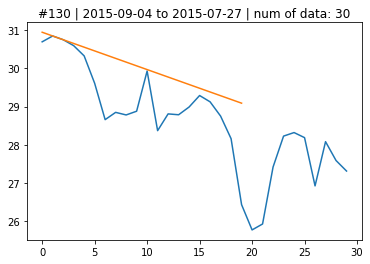

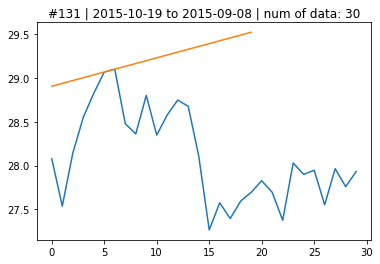

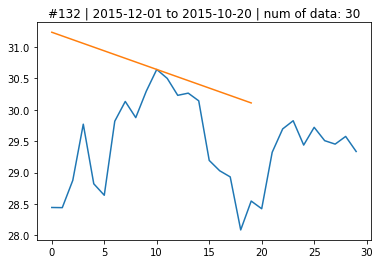

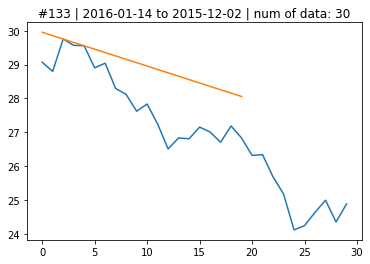

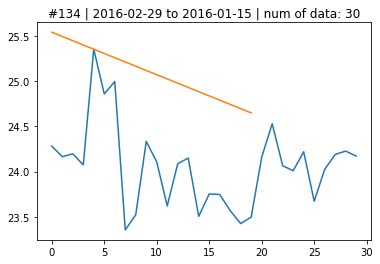

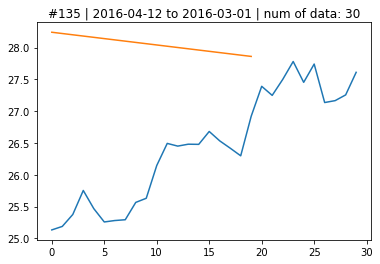

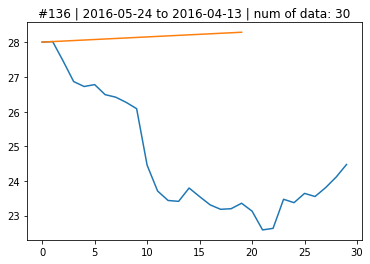

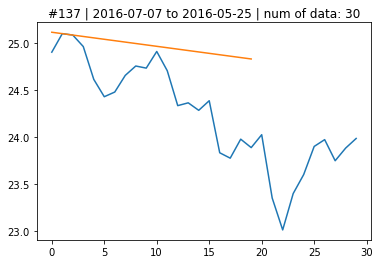

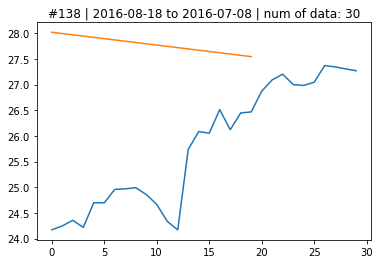

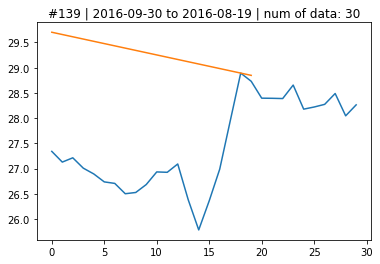

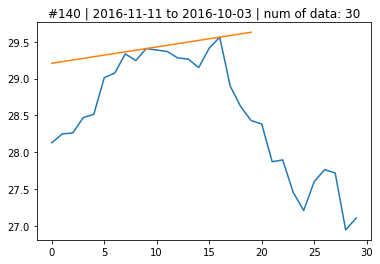

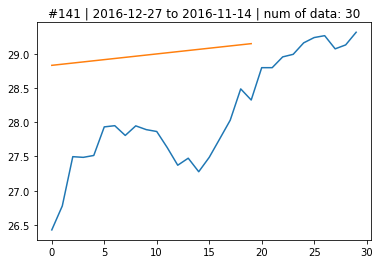

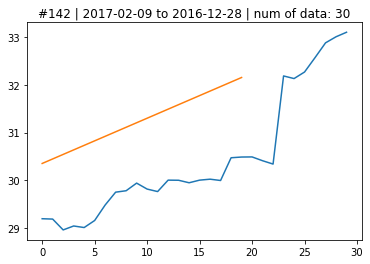

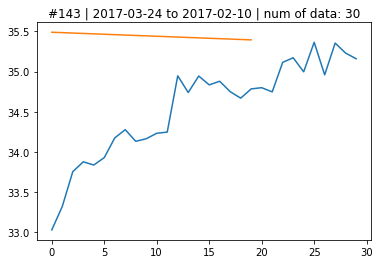

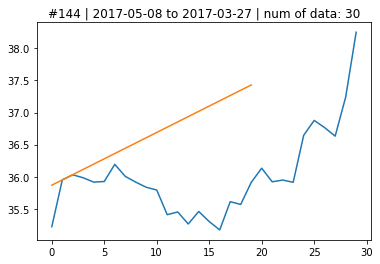

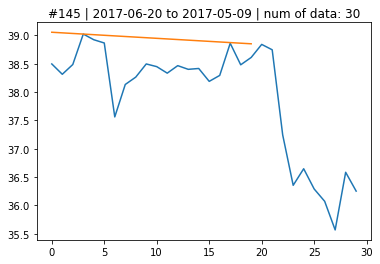

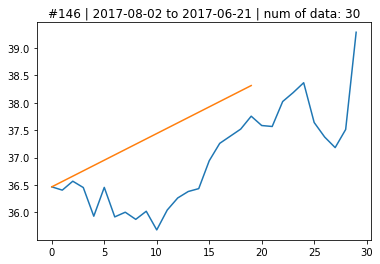

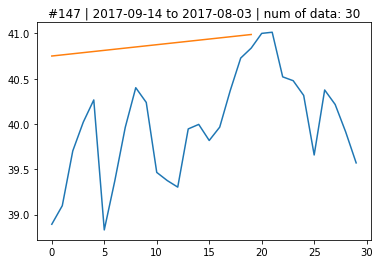

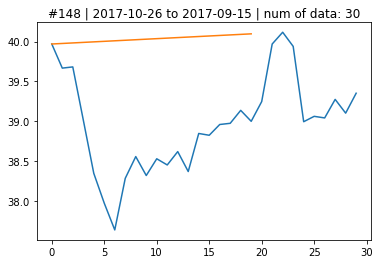

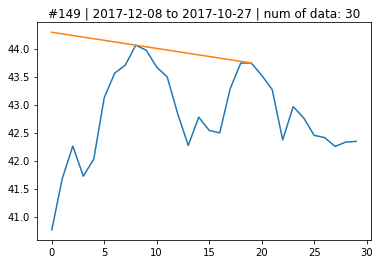

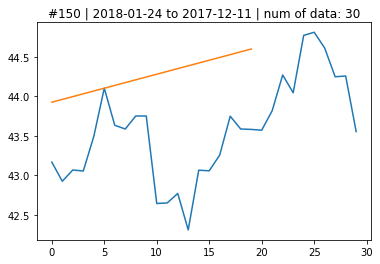

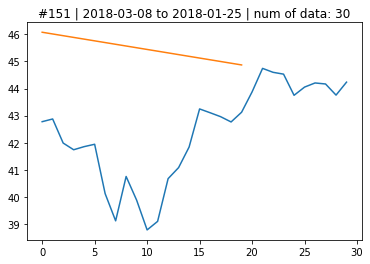

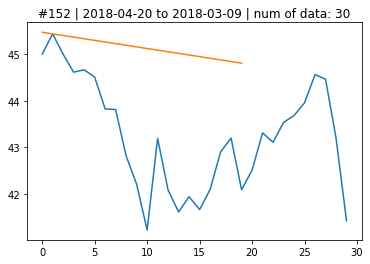

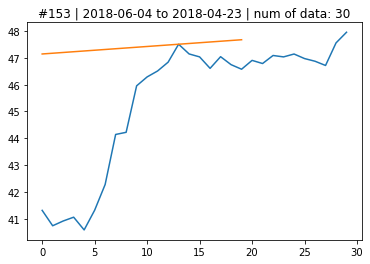

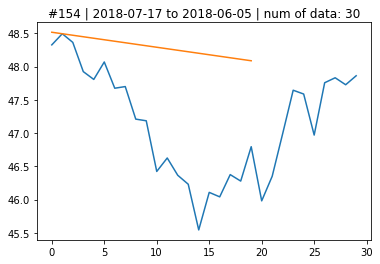

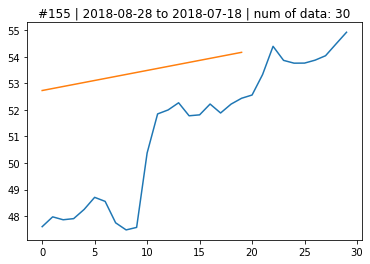

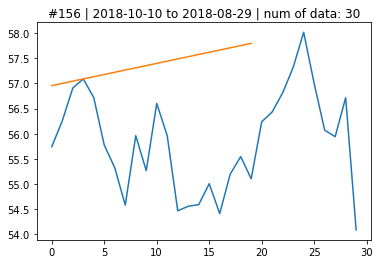

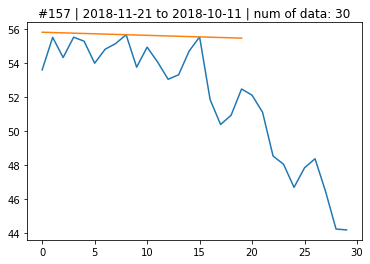

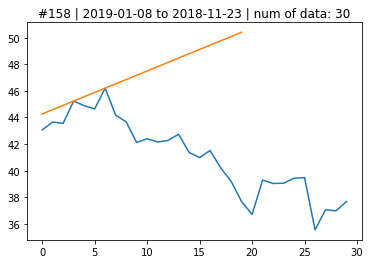

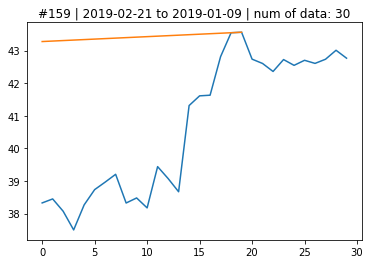

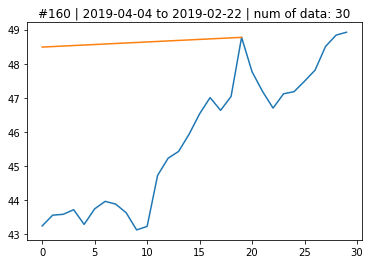

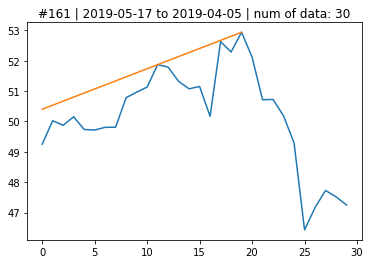

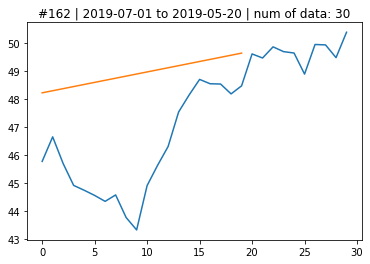

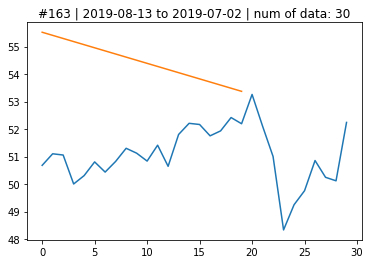

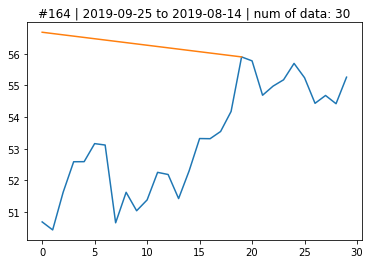

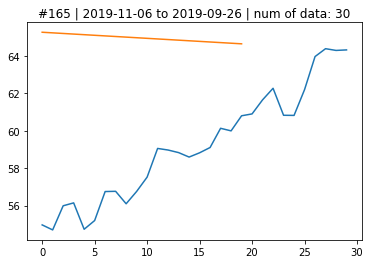

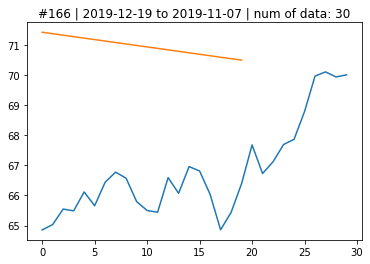

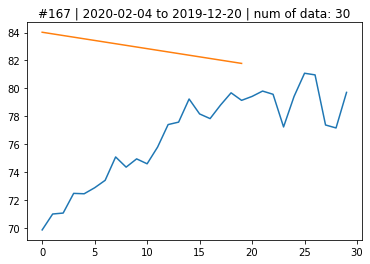

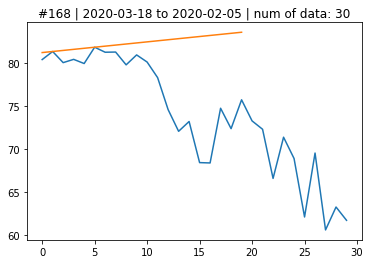

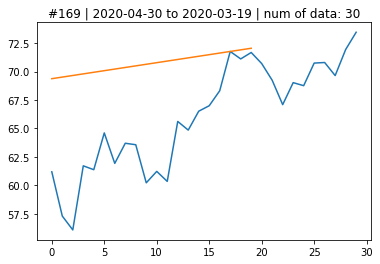

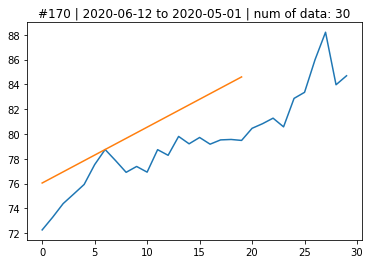

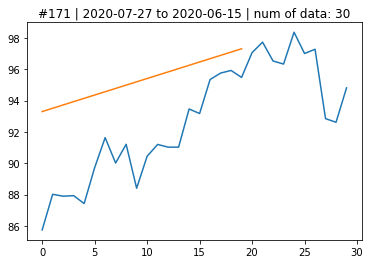

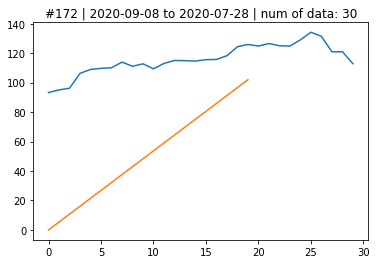

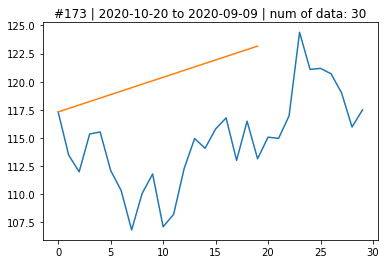

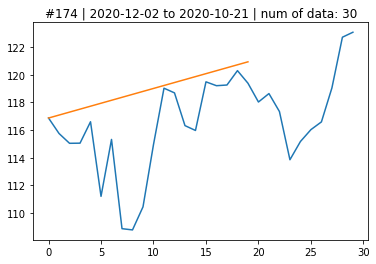

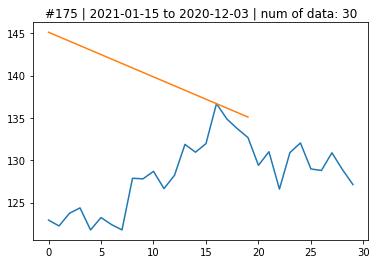

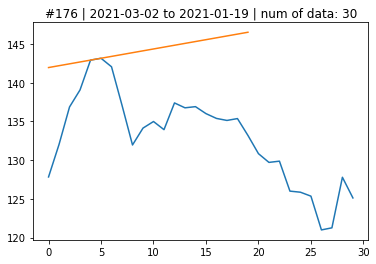

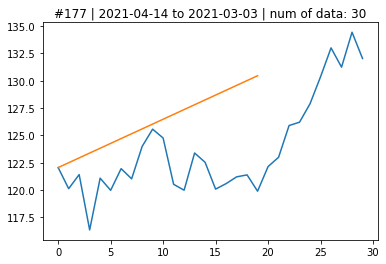

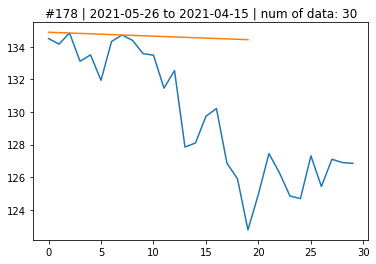

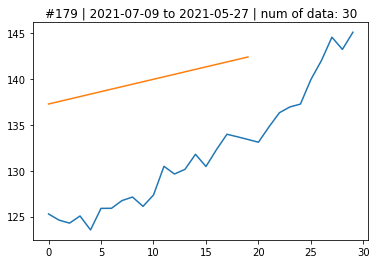

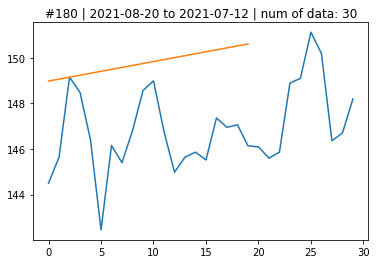

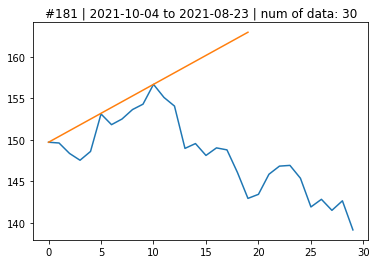

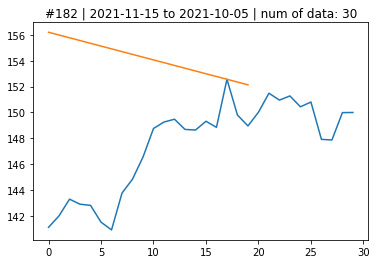

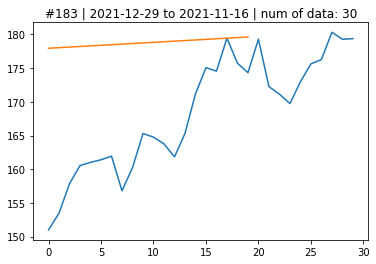

In [13]:
for ind, seg in enumerate(X_seg):
    if(len(seg) == DAY_PER_SEG):
        plotBySegment(seg, ind)
        #plotCandleBySegment(seg, ind)

**Collect valid data**

In [14]:
# Read in labels from external file
with open('label.txt') as f:
    labels = f.readlines()
    
labels = [c.strip() for c in labels]  # Remove whitespace characters like `\n` at the end of each line
print(labels)

['10', '14', '41', '59', '80', '92', '95', '103', '144', '147', '152', '149', '155', '162', '163', '173']


In [15]:
X_seg_valid = []
id = 0
for index, seg in enumerate(X_seg):
    if(len(seg) == DAY_PER_SEG):
            # Set the label of each day_dict
            label = 0
            if(str(index) in labels):
                label = 1
            for i, day_dict in enumerate(seg):
                seg[i]["label"] = label
                seg[i]["id"] = id
            
            X_seg_valid.append(seg)
            
            id += 1

In [16]:
print(len(X_seg_valid))

184


In [17]:
with open('output.csv', 'w') as csvfile:
    fieldnames = ['id', 'date', 'open', 'close', 'high', 'low', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for ind, seg in enumerate(X_seg_valid):
        for index, day_dict in enumerate(seg):
            writer.writerow({'id': seg[index]['id'], 'date': seg[index]['date'], 'open': seg[index]['open'], 'close': seg[index]['close'], 'high': seg[index]['high'], 'low': seg[index]['low'], 'label': seg[index]['label']})